In [5]:
import os
import ast
import argparse
import networkx as nx
from networkx.drawing.nx_pydot import write_dot


def get_module_name(file_path, repo_root):
    """Generate a module name from a file path relative to the repository root."""
    relative_path = os.path.relpath(file_path, repo_root)
    parts = relative_path.split(os.sep)
    if not parts:
        return ""
    if parts[-1] == "__init__.py":
        module_parts = parts[:-1]
    else:
        module_parts = parts.copy()
        if module_parts[-1].endswith(".py"):
            module_parts[-1] = module_parts[-1][:-3]
    return ".".join(module_parts)


def build_module_map(repo_root):
    """Build a mapping from module names to their file paths."""
    module_to_path = {}
    for root, _, files in os.walk(repo_root):
        for file in files:
            if file.endswith(".py"):
                file_path = os.path.join(root, file)
                module_name = get_module_name(file_path, repo_root)
                if module_name in module_to_path:
                    print(
                        f"Warning: Duplicate module {module_name} for {file_path} and {module_to_path[module_name]}"
                    )
                module_to_path[module_name] = file_path
    return module_to_path


def parse_imports(file_path, module_to_path, repo_root):
    """Parse import statements from a file and return edges for the graph."""
    current_module = get_module_name(file_path, repo_root)
    edges = []
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            tree = ast.parse(f.read(), filename=file_path)
    except (SyntaxError, UnicodeDecodeError):
        return edges  # Skip unparsable files

    for node in ast.walk(tree):
        if isinstance(node, ast.Import):
            for alias in node.names:
                imported_module = alias.name
                if imported_module in module_to_path:
                    edges.append((file_path, module_to_path[imported_module]))
        elif isinstance(node, ast.ImportFrom):
            if node.module == "__future__":
                continue  # Skip __future__ imports
            level = node.level
            absolute_module = None
            if level == 0:
                absolute_module = node.module
            else:
                current_parts = current_module.split(".") if current_module else []
                if len(current_parts) < level:
                    continue  # Invalid relative import
                base_parts = current_parts[:-level]
                if node.module:
                    absolute_parts = base_parts + node.module.split(".")
                else:
                    absolute_parts = base_parts
                absolute_module = ".".join(absolute_parts) if absolute_parts else None
            if not absolute_module:
                continue
            # Check the main module
            if absolute_module in module_to_path:
                edges.append((file_path, module_to_path[absolute_module]))
            # Check submodules from imported names
            for alias in node.names:
                submodule = f"{absolute_module}.{alias.name}"
                if submodule in module_to_path:
                    edges.append((file_path, module_to_path[submodule]))
    return edges


def main(repo_root, output_file):
    """Main function to build and export the import graph."""
    module_to_path = build_module_map(repo_root)
    graph = nx.DiGraph()
    # Add nodes and edges
    for file_path in module_to_path.values():
        graph.add_node(file_path)
    edges = []
    for file_path in module_to_path.values():
        edges.extend(parse_imports(file_path, module_to_path, repo_root))
    graph.add_edges_from(edges)
    # Write to DOT file
    write_dot(graph, output_file)
    print(f"Graph saved to {output_file}. Use Graphviz to render.")

In [6]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        description="Generate a dependency graph of Python imports."
    )
    parser.add_argument("repo_root", help="Path to the repository root directory")
    parser.add_argument("--output", default="graph.dot", help="Output DOT file name")
    # args = parser.parse_args()
    # main(args.repo_root, args.output)
    main("../follow-my-reading", "graph.dot")


Graph saved to graph.dot. Use Graphviz to render.


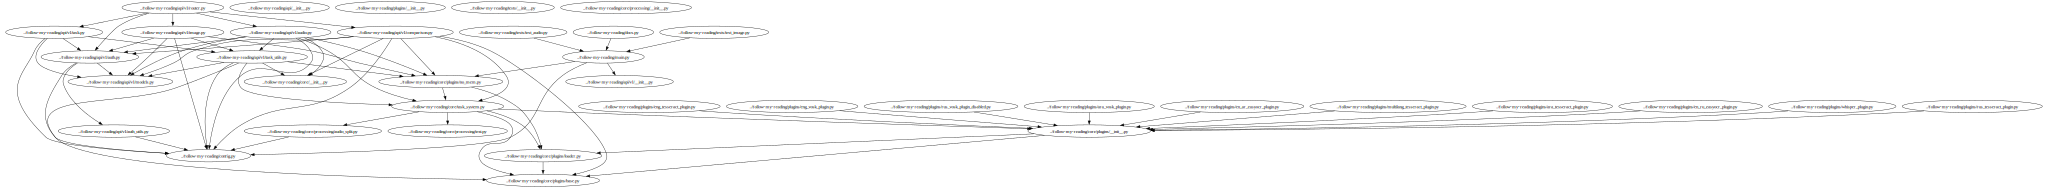

In [2]:
import graphviz

graphviz.Source.from_file('graph.dot')